In [23]:
import csv
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from statsmodels.tsa.tsatools import lagmat
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model


ts_dir = '/Users/danielfriedman/Desktop/dannys_macbook/timeseries/'
ts_dir = '/Users/joannafriedman/Desktop/dannys_macbook/timeseries/'
os.chdir(ts_dir)

In [24]:
mob = pd.read_csv(ts_dir + 'hendy/data/' + 'mobility-data-ts_2020-04-05.csv')
mob.rename(columns = {'seg':'cat'}, inplace = True)
cat_renamer = {'Retail & recreation':'retail',
              'Grocery & pharmacy':'grocery',
              'Parks':'parks',
              'Transit stations':'transit',
              'Workplace':'work',
              'Residential':'residential'}
mob['cat'].replace(cat_renamer, inplace = True)
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
mob['county'] = mob.county.str.replace('City', '').str.strip()

In [25]:
nyt = pd.read_csv(f'nyt/us-counties.csv')
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
nyt['county'] = nyt.county.str.replace('City', '').str.strip()

In [26]:
### TODO: match by county better

In [27]:
mobcounties = mob.county.unique()
nytcounties = nyt.county.unique()
print(len([c for c in mobcounties if c not in nytcounties]))
print(len([c for c in nytcounties if c not in mobcounties]))

201
145


In [28]:
merge = mob.merge(nyt, how = 'left', on = ['state','county','date'])
merge['cases'].fillna(0, inplace = True) # if it's nan, that means they hadn't had cases
merge['deaths'].fillna(0, inplace = True) # if it's nan, that means they hadn't had deaths

In [29]:
statename = 'New York'
countyname = 'New York'
preview = merge[(merge['state'] == statename) & (merge['county'] == countyname)]
preview.head()

,state,county,cat,conf,date,value,fips,cases,deaths
428538,New York,New York,retail,1,2020-02-23,0.195,NaN,0.0,0.0
428539,New York,New York,retail,1,2020-02-24,0.994,NaN,0.0,0.0
428540,New York,New York,retail,1,2020-02-25,-3.380,NaN,0.0,0.0
428541,New York,New York,retail,1,2020-02-26,-0.740,NaN,0.0,0.0
428542,New York,New York,retail,1,2020-02-27,1.015,NaN,0.0,0.0


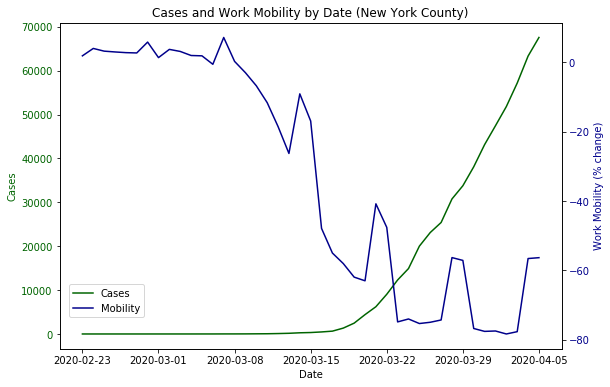

In [33]:
cat = 'work'
previewcat = preview[preview['cat'] == cat]

fig, ax1 = plt.subplots(figsize = (9, 6))
ax2 = ax1.twinx() 
sns.lineplot(previewcat.date, previewcat.cases, ax = ax1, color = 'darkgreen', label = 'Cases', legend = None)
sns.lineplot(previewcat.date, previewcat.value, ax = ax2, color = 'darkblue',  label = 'Mobility', legend = None)
ax1.set_xticks(previewcat.date[::7])
ax1.tick_params(axis='y', labelcolor='darkgreen')
ax1.set(xlabel = 'Date', ylabel = 'Cases')
ax1.set_ylabel('Cases', color = 'darkgreen')
ax2.tick_params(axis='y', labelcolor='darkblue')
ax2.set_ylabel('Work Mobility (% change)', color = 'darkblue')
ax1.set(title = f'Cases and Work Mobility by Date ({countyname} County)')
fig.legend(bbox_to_anchor=(0, 0, 0.23, 0.25));


In [34]:
work = merge[merge['cat'] == 'work']
retail = merge[merge['cat'] == 'retail']
grocery = merge[merge['cat'] == 'grocery']
parks = merge[merge['cat'] == 'parks']
transit = merge[merge['cat'] == 'transit']
residential = merge[merge['cat'] == 'residential']


#### Get metric of mobility

In [35]:
wide = merge.pivot_table(values=['value'], index=['date','state','county'], columns='cat', aggfunc='mean').reset_index()
wide.columns = ['_'.join(col).replace('_','').replace('value','') for col in wide.columns.to_flat_index()]
wide = wide.merge(nyt[['date','state','county','cases','deaths']], on = ['date','state','county'], how = 'left')
wide.head()


,date,state,county,grocery,parks,residential,retail,transit,work,cases,deaths
0,2020-02-23,Alabama,Autauga,3.053,NaN,NaN,-0.172,NaN,4.730,NaN,NaN
1,2020-02-23,Alabama,Baldwin,19.772,91.784,-2.036,16.863,18.656,4.320,NaN,NaN
2,2020-02-23,Alabama,Barbour,-8.594,NaN,NaN,3.272,NaN,4.548,NaN,NaN
3,2020-02-23,Alabama,Bibb,-1.868,NaN,NaN,-4.797,NaN,-1.666,NaN,NaN
4,2020-02-23,Alabama,Blount,5.528,NaN,NaN,3.571,NaN,1.310,NaN,NaN


In [36]:
# Standardize
fullcats = ['grocery','parks','residential','retail','transit','work']
cats = ['grocery','residential','retail','transit','work'] # note: only use these categories for building PCs
ss = SS().fit(wide[fullcats])
wide_standard = pd.DataFrame(ss.transform(wide[fullcats]), columns = fullcats)
wide_standard.fillna(0, inplace = True)

# PCA
N_COMPONENTS = 3
pca = PCA(n_components = N_COMPONENTS).fit(wide_standard)
pcs = ['pc'+str(i) for i in range(N_COMPONENTS)]
wide[pcs] = pd.DataFrame(pca.transform(wide_standard))
wide.head()

,date,state,county,grocery,parks,residential,retail,transit,work,cases,deaths,pc0,pc1,pc2
0,2020-02-23,Alabama,Autauga,3.053,NaN,NaN,-0.172,NaN,4.730,NaN,NaN,0.808834,-0.364005,-0.419919
1,2020-02-23,Alabama,Baldwin,19.772,91.784,-2.036,16.863,18.656,4.320,NaN,NaN,2.227585,0.106137,0.199674
2,2020-02-23,Alabama,Barbour,-8.594,NaN,NaN,3.272,NaN,4.548,NaN,NaN,0.557037,-0.923572,-0.781675
3,2020-02-23,Alabama,Bibb,-1.868,NaN,NaN,-4.797,NaN,-1.666,NaN,NaN,0.367607,-0.488169,-0.384742
4,2020-02-23,Alabama,Blount,5.528,NaN,NaN,3.571,NaN,1.310,NaN,NaN,0.859540,-0.194369,-0.399176


In [37]:
### TODO: fix this shit 

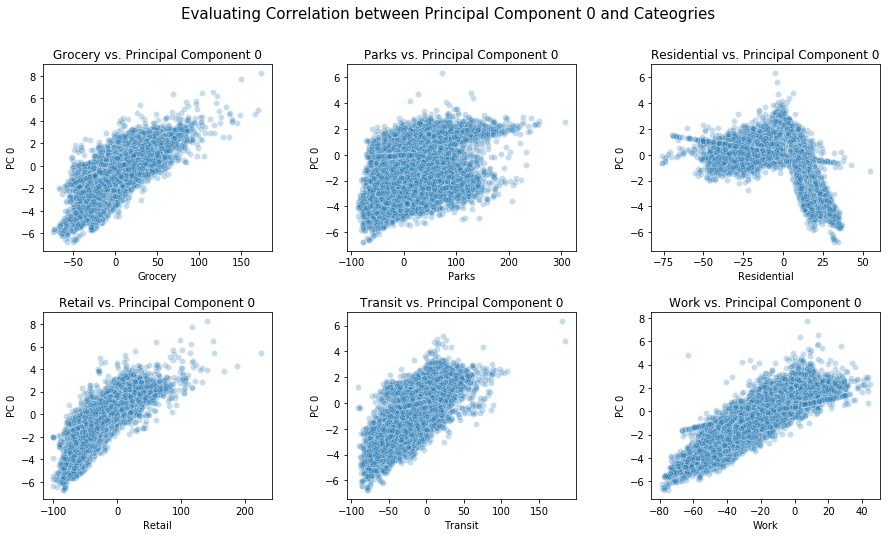

In [38]:
component = 0
fig, axes = plt.subplots(2, 3, figsize = (15,8))
for i, ax in enumerate(axes.ravel()):
    sns.scatterplot(wide[fullcats[i]], wide[f'pc{component}'], ax = ax, alpha = 0.25);
    ax.set(xlabel = fullcats[i].capitalize(),
           ylabel = 'PC '+str(component), 
           title = fullcats[i].capitalize() + ' vs. Principal Component ' + str(component))
fig.subplots_adjust(hspace = .33, wspace = .33);
fig.suptitle(f'Evaluating Correlation between Principal Component {component} and Cateogries', fontsize = 15);

#### Baseline Model

In [49]:
predictors = pcs
target = 'cases'
wide_nonull = wide[~pd.isnull(wide['cases'])].reset_index(drop = 1) # TODO: 
wide_nonull.head()

,date,state,county,grocery,parks,residential,retail,transit,work,cases,deaths,pc0,pc1,pc2
0,2020-02-23,Arizona,Maricopa,0.719,6.355,-0.517,6.678,7.927,1.633,1.0,0.0,1.058622,-0.688833,-0.296027
1,2020-02-23,California,Humboldt,0.378,20.541,0.235,4.607,-18.307,-0.269,1.0,0.0,0.675475,-0.492823,-0.388823
2,2020-02-23,California,Los Angeles,0.517,13.355,-0.363,3.661,0.417,1.585,1.0,0.0,0.912384,-0.643085,-0.273378
3,2020-02-23,California,Orange,-0.840,10.333,-0.296,4.656,-0.255,1.485,1.0,0.0,0.879719,-0.703615,-0.337814
4,2020-02-23,California,Sacramento,1.841,52.818,-0.793,7.632,4.011,1.364,1.0,0.0,1.161102,-0.590122,-0.225248


In [40]:
def get_TSG(df, target, predictors, length, batch_size = 1, sampling_rate = 1, stride = 1):
    cols = list(predictors) + [target]
    
    output = data[target]
    output = lagmat(output, maxlag = N_AHEAD, trim = 'backward')[:,::-1]
    
    tsg = TSG(data = np.array(df[cols]),
              targets = output,
              length = length,
              batch_size = batch_size,
              sampling_rate = sampling_rate,
              stride = stride)
    return tsg
              
bycounty = wide_nonull.groupby(['state','county'])

In [41]:
### TODO: have to make it so you don't predict too far ahead where it just fills in 0s

In [42]:
tsg_len = 0
N_STEPS = 10
N_FEATURES = len(predictors) + 1
N_AHEAD = 3
tsgs = []
tsg_county_tags = []

from statsmodels.tsa.tsatools import lagmat


for (state, county), data in bycounty:
    if len(data) <= N_STEPS + N_AHEAD - 1:
        continue
        
    temp = data.copy()
    # get timeseries generator
    tsg = get_TSG(data, target, predictors, N_STEPS)
    tsgs.append(tsg)
    tsg_len += len(tsg) - N_AHEAD + 1
    tsg_county_tags.extend([(state, county) for i in range(len(tsg) - N_AHEAD + 1)])

X = np.empty((tsg_len, N_STEPS, N_FEATURES))
y = np.empty((tsg_len, N_AHEAD))
counter = 0
for tsg in tsgs:
    for j in range(len(tsg) - N_AHEAD + 1):
        X[counter] = tsg[j][0][0]
        y[counter] = tsg[j][1][0]
        counter += 1

In [43]:
### TODO: change structure!

In [44]:
INPUT_SHAPE = (N_STEPS, N_FEATURES)
N_UNITS = 32

mod_name = 'baseline_3pc'
mod = Sequential(name = mod_name)
mod.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, return_sequences = True, name = 'LSTM_1'))
mod.add(Dropout(0.1, name = 'dropout'))
mod.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, name = 'LSTM_2'))
mod.add(Dense(N_AHEAD, activation='linear', name = 'Dense_Activation'))
mod.compile(loss='mse', optimizer='adam')
print(mod.summary())

VERBOSE = 2
# N_EPOCHS = 250
N_EPOCHS = 3
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.1
history = mod.fit(X, y,
                  batch_size = BATCH_SIZE,
                  epochs = N_EPOCHS,
                  verbose = VERBOSE,
                  validation_split = VALIDATION_SPLIT)
# mod.save(f'models/{mod_name}.h5')
pd.DataFrame(history.history).to_csv(f'models/{mod_name}.csv')


Model: "baseline_3pc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 10, 32)            4736      
_________________________________________________________________
dropout (Dropout)            (None, 10, 32)            0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
Dense_Activation (Dense)     (None, 3)                 99        
Total params: 13,155
Trainable params: 13,155
Non-trainable params: 0
_________________________________________________________________
None
Train on 8802 samples, validate on 979 samples
Epoch 1/3
8802/8802 - 9s - loss: 2682937.8946 - val_loss: 91670.6995
Epoch 2/3
8802/8802 - 5s - loss: 2679359.3476 - val_loss: 90278.2072
Epoch 3/3
8802/8802 - 4s - loss: 2676326.0341 - val_loss: 

In [45]:
# mod = load_model(f'models/{mod_name}.h5')

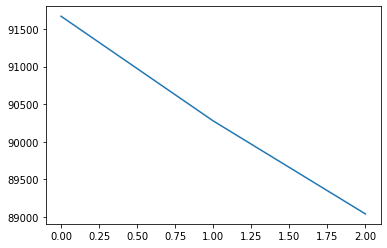

In [46]:
sns.lineplot(np.arange(len(history.history['val_loss'])), history.history['val_loss']);

In [47]:
(statename, countyname) = ('New York', 'New York')
tsg_county_index = np.array([(j[0], j[1]) == (statename, countyname) for j in tsg_county_tags])
X_county = X[tsg_county_index]
y_county = y[tsg_county_index]
y_pred = mod.predict(X_county)

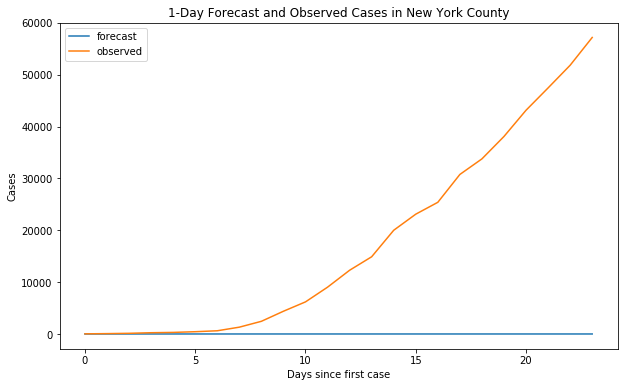

In [48]:
d = 0
fig, ax = plt.subplots(figsize = (10,6))
dates = wide_nonull[(wide_nonull['state'] == statename) & (wide_nonull['county'] == countyname)].date
sns.lineplot(np.arange(len(y_pred)), y_pred[:,d], label = 'forecast')
sns.lineplot(np.arange(len(y_county)), y_county[:,d], label = 'observed')
ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d+1}-Day Forecast and Observed Cases in {countyname} County');

